# 【問題1】ジニ不純度を求める関数
###### まずは空間を分割するための指標値、ジニ不純度を計算する関数を作成してください。
###### ノードtに対するジニ不純度I(t)は以下の数式で求まります。

$
I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}
$

クラス数は２で作成

In [1]:
import numpy as np
import collections
import pandas as pd

In [2]:
#ジニ係数を求める関数を作成
def gini_(y):
    y = np.array(y).flatten()
    gini = 1
    class_counts_set = collections.Counter(y) # collections.Counter()はクラスの種類とその数をカウントする関数
    for key in class_counts_set:
        if len(y) > 0:
            gini -= (class_counts_set[key]/len(y))**2
        else:
            gini = 0    
    return gini

In [42]:
y = np.array([0,1,1,1,0,1,0,0,0,2,2,0])
y_2 = np.array([0,0,1,1])
gini_(y) 

Counter({0: 6, 1: 4, 2: 2})

# 【問題2】情報利得を求める関数
###### 次に、情報利得を計算する関数を作成してください。先ほど作成したジニ不純度 I(t)を計算する関数を呼び出して使います。
###### 情報利得IGは以下の数式で求まります。

$
 IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)
$

In [4]:
def information_gain_(parent_node,left_node,right_node):
    parent_node_gini = gini_(parent_node) #親ノードのジニ不純度
    left_node_gini = gini_(left_node) #左ノードのジニ不純度
    right_node_gini = gini_(right_node) #右ノードのジニ不純度
    
    return parent_node_gini \
            - len(left_node)/len(parent_node) * left_node_gini \
            - len(right_node)/len(parent_node) * right_node_gini

In [5]:
parent_node = [0,0,0,0,1,1,1,1]
left_node = [0,1,1,1]
right_node = [0,0,0,1]

In [6]:
information_gain_(parent_node,left_node,right_node)

0.125

# 【問題3】深さ1の決定木分類器クラスの作成
###### 深さが1の決定機分類器のクラスを作成し、Sprint2で作成した分類のパイプラインに組み込んでください。
###### クラスの基本構造はSprint3の線形回帰を参考にし、名前はScratchDecesionTreeClassifierとしてください。
###### メソッドやパラメータなどはscikit-learnを参考にしてください。
###### sklearn.tree.DecisionTreeClassifier — scikit-learn 0.20.2 documentation
###### 検証段階ではJupyter Notebook上で書いていき、最終的にはpyファイルにモジュールとしてまとめてください。
###### 深さ1とは空間の分割を1回だけ行うことを指します。
###### 決定木のアルゴリズム
###### ある特徴量の軸に対して、全てのパターンのしきい値を考え、それぞれの情報利得を計算していきます。各点の値をしきい値にする方法が一般的です。（ただし、実際にはしきい値の数は点の数よりひとつ少なくて良いことになります）分割の全候補の中で最も情報利得が大きくなるものをそのノードの分割方法として採用します。
###### ジニ不純度が0になるノード、または指定された深さのノードは葉と呼ばれます。葉にはそれぞれ推定時にどのクラスに分類するかを記録しておきます。ジニ不純度が0でない場合は、多数決により分類するクラスを決定します。
###### ヒント
###### これまでのスクラッチ課題に比べてアルゴリズムが複雑です。コードを書く前に、フローチャートなどで整理するようにしましょう。

In [114]:
import numpy as np
import collections
import pandas as pd

class decision_tree():
    
    """
    線形回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証用データに対する損失の記録

    """

    def __init__(self, verbose=False): 
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        
        self.max_information_gain = 0
        self.best_threshold_feature = 0
        self.best_threshold = 0        
        
        #左右のノードの予測結果
        self.left_predict = None
        self.right_predict = None

        
    def gini_(self,y):
        """
        ジニ係数を返す関数を作成
        引数yはラベルデータ
        yはnumpy配列に変換されて計算
        返り値gini不純度はスカラー
        """
        y = np.array(y).flatten()
        gini = 1
        class_counts_set = collections.Counter(y) # collections.Counter()はクラスの種類とその数をカウントする関数
        for key in class_counts_set:
            if len(y) > 0:
                gini -= (class_counts_set[key]/len(y))**2
            else:
                gini = 0
        return gini

    
    
    def information_gain_(self,parent_node,left_node,right_node):
        """
        情報利得を返す関数を作成
        引数は親ノード、子ノード_1、子ノード_2のデータ
        返り値はスカラー
        """
        parent_node_gini = self.gini_(parent_node) #親ノードのジニ不純度
        left_node_gini = self.gini_(left_node) #左ノードのジニ不純度
        right_node_gini = self.gini_(right_node) #右ノードのジニ不純度
        
        return parent_node_gini \
                - len(left_node)/len(parent_node) * left_node_gini \
                - len(right_node)/len(parent_node) * right_node_gini
                

    def fit(self, X, y, X_val=None, y_val=None):
        """
        決定木を作成する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値

        
        親ノードの特徴量Xとクラスyのデータを入れると、
        最適な左ノードと右ノードのXとyを返す関数
        """""""""""""""""""""


    
        max_informaion_gain = 0
        self.threshold = 0
        child_left_node_label = []
        child_right_node_label = []
        
        
        for n in range(0,X.shape[1]): #全ての特徴量に関して繰り返す
            for i_fixed in range(0,X.shape[0]): #全てのサンプルに関してしきい値を設定してみる
                #閾値に対する大小により、左右のノードに入るサンプルのインデックスを格納する。
                left_index = np.where(X[:,n] < X[i_fixed,n])
                right_index = np.where(X[i_fixed,n] <= X[:,n])
                
                #情報利得を計算し、その時点の情報利得の最大値を超えていれば更新
                if self.information_gain_(y,y[left_index],y[right_index]) > self.max_information_gain :
                    self.best_threshold_feature = n
                    self.best_threshold = X[i_fixed,n]
                    self.max_information_gain = self.information_gain_(y,y[left_index],y[right_index])
                    max_information_gain_child_left_node_y = y[left_index] #左ノードの特徴量とデータを更新格納
                    max_information_gain_child_right_node_y = y[right_index] #右ノードの特徴量とデータを更新格納
                else:
                    """""""""""""""
                    情報利得とその際のノードは最終的なインデックスでまとめて計算可能
                    max_information_gain = information_gain_(y,y[left_index],y[right_index]) 
                    max_information_gain_child_left_node_X = X[left_index]
                    max_information_gain_child_left_node_y = y[left_index]
                    max_information_gain_child_right_node_X = X[right_index]
                    max_information_gain_child_right_node_y = y[right_index]
                    child_left_node_label = 
                    """""""""""""""

        #左右のノードに予測結果を設定
        max_information_gain_child_left_node_y_collectins = collections.Counter(max_information_gain_child_left_node_y.flatten())
        max_information_gain_child_right_node_y_collectins = collections.Counter(max_information_gain_child_right_node_y.flatten())
        values_left, counts_left = zip(*max_information_gain_child_left_node_y_collectins.most_common())
        values_right, counts_right = zip(*max_information_gain_child_right_node_y_collectins.most_common())
        self.left_predict = values_left[0]
        self.right_predict = values_right[0]
        
        
        
        return  "最大の情報利得",self.max_information_gain, \
                "閾値となる特徴量の列番号と閾値:",self.best_threshold_feature,self.best_threshold, \
                "左ノードに判定された場合のラベル",self.left_predict, \
                "右ノードに判定された場合のラベル",self.right_predict 
    

    def predict(self, X):
        """
        決定木を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        y_pred = []
        
        #最終的に設定した閾値によってｙ_predを予測する
        for i in range(X.shape[0]):
            if X[i,self.best_threshold_feature] < self.best_threshold:
                y_pred.append(self.left_predict)  
            else :
                y_pred.append(self.right_predict)
        
        return  np.array(y_pred)

# 【問題6】指標値の算出
###### 分類に関する指標値で精度を確認してください。

In [20]:
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df_new = df[df['target']<2]
X = df_new.iloc[:,[0,1]].values
y = df_new.loc[:,'target'].values.reshape(-1,1)
#学習データ、検証データ分割
from sklearn.model_selection import train_test_split
X, X_val, y, y_val = train_test_split(X, y,test_size=0.3)

In [21]:
decision = decision_tree()
decision.fit(X,y)
y_pred = decision.predict(X_val) #予測

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc
print('正解率:', accuracy_score(y_pred,y_val))
print('適合率:', precision_score(y_pred,y_val))
print('再現率:', recall_score(y_pred,y_val))
print('F1スコア:', f1_score(y_pred,y_val))
#print('AUCスコア:', auc(y_pred,y_val))

正解率: 0.9333333333333333
適合率: 0.8823529411764706
再現率: 1.0
F1スコア: 0.9375


# 【問題7】決定領域の可視化
###### 2値分類のデータセットに対して決定領域を可視化してください

In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np

def decision_region(X_train, y_train, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は学習用データである。

    Parameters
    ----------------
    X_train : ndarray, shape(n_samples, 2)
        学習用データの特徴量
    y_train : ndarray, shape(n_samples,)
        学習用データの正解値
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y_train)):
        plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

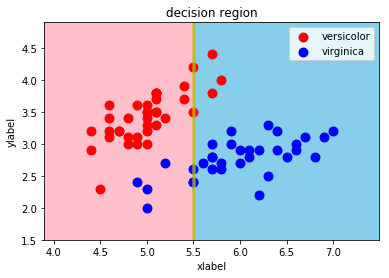

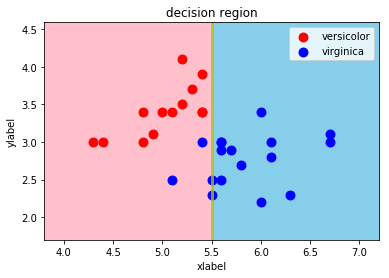

In [23]:
decision_region(X,y.ravel(),decision,xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica'])
decision_region(X_val,y_val.ravel(),decision,xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica'])

# 【問題8】決定木の利用場面
###### 最終発表時に以下の内容についてディスカッションを行います。自分なりの意見を用意しておいてください。
###### 決定木が他の手法に比べて有効だと考えられるのはどういった場面か

<font color="blue">
<li>決定木は二次元データのみならず、多次元データによる予測を行なった場合にも可視化がしやすく、分析に説明性が求められる場面で有効である。
<li>予測精度のみを追う場面ではなく、原因分析やビジネス上の打ち手を別途検討する場合に活用可能。
</font>

# 【問題4】（アドバンス課題）深さ2の決定木分類器クラスの作成
###### 問題3で作成したクラスを発展させ、深さが2の決定木分類器のクラスを作成してください。
###### 深さ2とは空間の分割を2回行うことを指します。
###### ヒント:各ノードをインスタンスとして扱うと、任意の深さへの拡張が行いやすくなります。

In [111]:
import numpy as np
import collections
import pandas as pd

class decision_tree_2():
    
    """
    線形回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証用データに対する損失の記録

    """

    def __init__(self, verbose=False): 
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        
        self.max_information_gain = 0
        self.best_threshold_feature = 0
        self.best_threshold = 0        
        
        #左右のノードの予測結果
        self.left_predict = None
        self.right_predict = None

        
    def gini_(self,y):
        """
        ジニ係数を返す関数を作成
        引数yはラベルデータ
        yはnumpy配列に変換されて計算
        返り値gini不純度はスカラー
        """
        y = np.array(y).flatten()
        gini = 1
        class_counts_set = collections.Counter(y) # collections.Counter()はクラスの種類とその数をカウントする関数
        for key in class_counts_set:
            if len(y) > 0:
                gini -= (class_counts_set[key]/len(y))**2
            else:
                gini = 0
        return gini
        
    
    def information_gain_(self,parent_node,left_node,right_node):
        """
        情報利得を返す関数を作成
        引数は親ノード、子ノード_1、子ノード_2のデータ
        返り値はスカラー
        """
        parent_node_gini = self.gini_(parent_node) #親ノードのジニ不純度
        left_node_gini = self.gini_(left_node) #左ノードのジニ不純度
        right_node_gini = self.gini_(right_node) #右ノードのジニ不純度
        
        return parent_node_gini \
                - len(left_node)/len(parent_node) * left_node_gini \
                - len(right_node)/len(parent_node) * right_node_gini
                

    
    def split_(self, X, y):
        max_informaion_gain = 0
        child_left_node_label = []
        child_right_node_label = []
        
        """
        global max_information_gain_child_left_node_y
        global max_information_gain_child_right_node_y
        global max_information_gain_child_left_node_X
        global max_information_gain_child_left_node_y
        global max_information_gain_child_right_node_X
        global max_information_gain_child_right_node_y
        global left_predict
        global right_predict
        global max_information_gain
        global best_threshold_feature, best_threshold
        """
        
        
        
        
        #決定木分割
        for n in range(0,X.shape[1]): #全ての特徴量に関して繰り返す
            for i_fixed in range(0,X.shape[0]): #全てのサンプルに関してしきい値を設定してみる
                #閾値に対する大小により、左右のノードに入るサンプルのインデックスを格納する。
                left_index = np.where(X[:,n] < X[i_fixed,n])
                right_index = np.where(X[i_fixed,n] <= X[:,n])
                
                #情報利得を計算し、その時点の情報利得の最大値を超えていれば更新
                if self.information_gain_(y,y[left_index],y[right_index]) > self.max_information_gain :
                    best_threshold_feature = n
                    best_threshold = X[i_fixed,n]
                    max_information_gain = self.information_gain_(y,y[left_index],y[right_index])
                    max_information_gain_child_left_node_y = y[left_index] #左ノードのラベルを更新格納
                    max_information_gain_child_right_node_y = y[right_index] #右ノードのラベルを更新格納
                    max_information_gain_child_left_node_X = X[left_index] #左ノードの特徴量を更新格納
                    max_information_gain_child_right_node_X = X[right_index] #右ノードの特徴量を更新格納
                    
         
        
        #左右のノードに予測結果を設定 ★
        print("max_", max_information_gain_child_left_node_y)
        print("max_", max_information_gain_child_left_node_y.flatten())
        #print("max_information_gain_child_left_node_", max_information_gain_child_left_node_y.flatten())
        #print("max_information_gain_child_left_node_", max_information_gain_child_left_node_y)
        
        max_information_gain_child_left_node_y_collectins = collections.Counter(max_information_gain_child_left_node_y.flatten())
        max_information_gain_child_right_node_y_collectins = collections.Counter(max_information_gain_child_right_node_y.flatten())
        values_left, counts_left = zip(*max_information_gain_child_left_node_y_collectins.most_common())
        values_right, counts_right = zip(*max_information_gain_child_right_node_y_collectins.most_common())
        left_predict = values_left[0]
        right_predict = values_right[0]
        
        
        
        return  max_information_gain_child_left_node_X, max_information_gain_child_left_node_y, \
                max_information_gain_child_right_node_X, max_information_gain_child_right_node_y, \
                left_predict, right_predict, \
                max_information_gain, best_threshold_feature, best_threshold
                

    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        決定木を作成する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値

        
        親ノードの特徴量Xとクラスyのデータを入れると、
        最適な左ノードと右ノードのXとyを返す関数
        """""""""""""""""""""
        
        self.first_best_threshold_feature = 0
        self.first_best_threshold = 0        
        self.second_best_threshold_feature = 0
        self.second_best_threshold = 0
        self.split_node = ''
        self.final_node_1_predict = 0
        self.final_node_2_predict = 0
        self.final_node_3_predict = 0
        
        
                        
        #１回目の決定木分割
        left_X, left_y, right_X, right_y, left_predict, right_predict, max_information_gain, best_threshold_feature, best_threshold \
        = self.split_(X,y)
        
        self.first_best_threshold_feature = best_threshold_feature
        self.first_best_threshold = best_threshold
        
    
        #２回目の決定木分割
        #左ノード分割
        left_left_X, left_left_y, left_right_X, left_right_y, left_left_predict, left_right_predict, \
        left_max_information_gain,left_best_threshold_feature, left_best_threshold \
        = self.split_(left_X,left_y)
        
        
        #右ノード分割
        right_left_X, right_left_y, right_right_X, right_right_y, right_left_predict, right_right_predict, \
        right_max_information_gain, right_best_threshold_feature, right_best_threshold \
        = self.split_(right_X,right_y)        
        
        
        #左右のノードの情報利得を比較し、情報利得が大きな方を選択
        if left_max_information_gain >= right_max_information_gain:
            
            #2回目に分割する側のノードの記録
            self.split_node = 'left'
            
            #２回目の分割に使った特徴量と閾値
            self.second_best_threshold_feature = left_best_threshold_feature
            self.second_best_threshold = left_best_threshold
            
            #分割１回で作成され残ったノード
            final_node_1_X = right_X
            final_node_1_y = right_y
            self.final_node_1_predict = right_predict       
                        
            #分割二回の左側ノード
            final_node_2_X = left_left_X
            final_node_2_y = left_left_y
            self.final_node_2_predict = left_left_predict
        
            #分割二回の右側ノード
            final_node_3_X = left_right_X
            final_node_3_y = left_right_y
            self.final_node_3_predict = left_right_predict
                
            
        else:
            #2回目に分割する側のノードの記録
            self.split_node = 'right'
            
            #２回目の分割に使った特徴量と閾値
            self.second_best_threshold_feature = right_best_threshold_feature
            self.second_best_threshold = right_best_threshold            
            
            #分割１回で作成され残ったノード
            final_node_1_X = left_X
            final_node_1_y = left_y
            self.final_node_1_predict = left_predict    
                        
            #分割二回の左側ノード
            final_node_2_X = right_left_X
            final_node_2_y = right_left_y
            self.final_node_2_predict = right_left_predict
        
            #分割二回の右側ノード
            final_node_3_X = right_right_X
            final_node_3_y = right_right_y
            self.final_node_3_predict = right_right_predict          
        

    def predict(self, X):
        """
        決定木を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        y_pred = []
        
        #最終的に設定した閾値によってｙ_predを予測する
        for i in range(X.shape[0]):
            
            #左ノードを分割した場合
            if self.split_node == 'left':
                if X[i,self.first_best_threshold_feature] < self.first_best_threshold:
                    if X[i,self.second_best_threshold_feature] < self.second_best_threshold:
                        y_pred.append(self.final_node_2_predict)
                    else :
                        y_pred.append(self.final_node_3_predict)
                else :
                    y_pred.append(self.final_node_1_predict)
            
            #右ノードを分割した場合
            if self.split_node == 'right':
                if X[i,self.first_best_threshold_feature] < self.first_best_threshold:
                    y_pred.append(self.final_node_1_predict) 
                    
                elif X[i,self.second_best_threshold_feature] < self.second_best_threshold:
                    y_pred.append(self.final_node_2_predict)
                else :
                    y_pred.append(self.final_node_3_predict)
                    
        return  np.array(y_pred)

In [62]:
collections.Counter([0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0])

SyntaxError: invalid syntax (<ipython-input-62-474247749028>, line 1)

In [84]:
collections.Counter([0, 1])

np.array([[0, 1]]).ravel()

array([0, 1])

In [48]:
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df_new = df[df['target']<2]
X = df_new.iloc[:,[0,1]].values
y = df_new.loc[:,'target'].values.reshape(-1,1)
#学習データ、検証データ分割
from sklearn.model_selection import train_test_split
X, X_val, y, y_val = train_test_split(X, y,test_size=0.3)

In [93]:
y.flatten()

array([0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0])

In [112]:
tree_2 = decision_tree_2()

In [64]:
tree_3 = decision_tree_2()

In [65]:
tree_3.fit(X,y)

max_information_gain_child_left_node_y.flatten() <class 'numpy.ndarray'>
max_information_gain_child_left_node_y.flatten() <class 'numpy.ndarray'>
max_information_gain_child_left_node_y.flatten() <class 'numpy.ndarray'>


In [ ]:
[0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0]
[0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0]

In [59]:
tree_3.fit(X,y)

max_information_gain_child_left_node_y.flatten() [0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1
 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0]
max_information_gain_child_left_node_y.flatten() [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1
 1 1 1 0 1 1]
max_information_gain_child_left_node_y.flatten() [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1
 1 1 1 0 1 1]


In [113]:
tree_2.fit(X,y)

max_ [[0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]]
max_ [0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1
 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0]
max_ [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]]
max_ [1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1
 1 1 1 0 1 1]


UnboundLocalError: local variable 'max_information_gain_child_left_node_y' referenced before assignment

In [98]:
tree_2.fit(X,y)
y_pred_2 = tree_2.predict(X)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc
print('正解率:', accuracy_score(y_pred_2,y))
print('適合率:', precision_score(y_pred_2,y))
print('再現率:', recall_score(y_pred_2,y))
print('F1スコア:', f1_score(y_pred_2,y))

max_information_gain_child_left_node_y.flatten() [[0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]]
max_information_gain_child_left_node_ [0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1
 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 1 0]
max_information_gain_child_left_node_ [[0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]]
max_information_gain_child_left_node_y.flatten() [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1

UnboundLocalError: local variable 'max_information_gain_child_left_node_y' referenced before assignment

In [51]:
def decision_region(X_train, y_train, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は学習用データである。

    Parameters
    ----------------
    X_train : ndarray, shape(n_samples, 2)
        学習用データの特徴量
    y_train : ndarray, shape(n_samples,)
        学習用データの正解値
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y_train)):
        plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

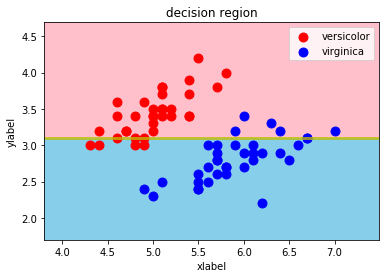

In [29]:
decision_region(X,y.ravel(),tree_2,xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica'])

# 写経用？

In [120]:
from collections import defaultdict

class Sample():

    def __init__(self, label=0, features=[]):
        self.label    = label
        self.features = features

# ----------------------------------------------------------------------------

class Node():

    def __init__(self, level=0):
        self.level       = level # 階層の深さ
        self.l_node      = None  # 子ノード(左)
        self.r_node      = None  # 子ノード(右)
        self.t_value     = None  # 閾値
        self.feature_idx = None  # どの値で分けるか
        self.label       = None  # 分類すべきラベル
        self.samples     = []    # 属するサンプル


    def __str__(self):
        if self.is_leaf():
            return "[%3s] Samples:%3s" % (self.level, len(self.samples))
        else:
            return "[%3s] Feature Idx:%3s, Threashold: %5s" % (self.level, self.feature_idx, self.t_value)


    def is_leaf(self):
        return (self.l_node is None) and (self.r_node is None)


    def child_nodes(self):
        return filter(None, [self.l_node, self.r_node])


    def classify(self, feature):
        node  = self
        label = None

        f = feature[node.feature_idx]
        while node:
            if node.is_leaf():
                label = node.label
                break
            elif f < node.t_value:
                node = node.l_node
            else:
                node = node.r_node

        return label


    def build_child_nodes(self, n_class, samples, max_depth, min_samples):
        self.samples = samples
        n_features   = len(samples[0].features) # 説明変数の数

        # 最大の深さに達したら終わり
        if self.level >= max_depth:
            self.build_leaf()
            return

        # 分類した結果で最もいいもの
        best_feature_idx = None # 最もよく分類できた説明変数
        best_t_value     = None # 最もよく分類できた閾値
        best_gini        = 1    # 0に近づくほど平等
        best_l_samples   = []
        best_r_samples   = []

        # 説明変数の数だけ 分類して評価をする
        # 各説明変数で分類する(idx = 説明変数のindex)
        for idx in range(0, n_features-1):

            # 分類する説明変数を、ユニークにして昇順に並び替える
            features = map(lambda x: x.features[idx] , samples)
            features = list(set(features))
            features.sort()

            for i in range(0, len(features)-2):

                # 各説明変数の中間値で分類する.
                t_value = (features[i] + features[i+1]) / 2

                l_samples = []; l_sample_labels = defaultdict(lambda: 0)
                r_samples = []; r_sample_labels = defaultdict(lambda: 0)
                for s in samples:

                    if s.features[idx] < t_value:
                        l_samples.append(s)
                        l_sample_labels[s.label] += 1
                    else:
                        r_samples.append(s)
                        r_sample_labels[s.label] += 1

                # どちらかに偏ったらわける意味なし, 次の説明変数の計算
                if len(l_samples) == 0 or len(r_samples) == 0:
                    continue

                # 分割したものに対しての評価(Gini係数, 交差エントロピー)
                l_gini = 0; r_gini = 0
                for idx in range(0, n_class):
                    l_gini += (float(l_sample_labels[idx]) / len(l_samples)) ** 2
                    r_gini += (float(r_sample_labels[idx]) / len(r_samples)) ** 2

                # 全体のGini係数(l, rのgini係数の平均値を求める)
                gini = (((1-l_gini) * len(l_samples)) + ((1-r_gini) * len(r_samples))) / len(samples)

                # bestを上回っていたら更新する
                if gini < best_gini:
                    best_gini        = gini
                    best_t_value     = t_value
                    best_feature_idx = idx
                    best_l_samples   = l_samples
                    best_r_samples   = r_samples

        # どちらかに偏ったら新たに木を作らない
        if len(best_l_samples) == 0 or len(best_r_samples) == 0:
            self.build_leaf()
            return

        # min_samples に達してない場合もわける必要なし. 過学習対策
        if max(len(best_l_samples), len(best_r_samples)) < min_samples:
            self.build_leaf()
            return

        # 現在のノードの設定
        self.samples     = []
        self.t_value     = best_t_value
        self.feature_idx = best_feature_idx

        # ベストなものから新規ノード作成, 次のノードへ移る
        next_level = self.level + 1

        self.r_node = Node(next_level)
        self.r_node.build_child_nodes(n_class, best_r_samples, max_depth, min_samples)

        self.l_node = Node(next_level)
        self.l_node.build_child_nodes(n_class, best_l_samples, max_depth, min_samples)


    def build_leaf(self):
        self.label = self.samples[0].label

# ----------------------------------------------------------------------------

class DecisionTree():

    def __init__(self, max_depth=10, min_samples=3):
        self.root_node   = Node(level=1) # root node
        self.max_depth   = max_depth     # Treeの最大の深さ
        self.min_samples = min_samples   # Nodeに属する最小の要素数


    def fit(self, data, target):
        # ユニークな分類クラス数
        labels = list(set(target))

        # 学習用データ生成
        samples = []
        for idx, sample in enumerate(data):
            samples.append(Sample(features=data[idx], label=target[idx]))

        # 学習
        self.root_node.build_child_nodes(n_class=len(labels), samples=samples, max_depth=self.max_depth, min_samples=self.min_samples)


    def features(self):
        # レベル毎にNodeの特徴を出力する
        print(self.root_node)

        current_nodes = self.root_node.child_nodes()
        child_nodes   = []
        while current_nodes:
            node = current_nodes.pop(0)
            print(node)
            child_nodes.extend(node.child_nodes())

            if len(current_nodes) == 0 and len(child_nodes) > 0:
                current_nodes = child_nodes
                child_nodes   = []


    def predict(self, data):
        return self.root_node.classify(data)

In [122]:
tree = DecisionTree()

In [124]:
tree.fit(X,y.ravel())

In [127]:
tree.predict(X)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# 以下実験記録

In [81]:
c = collections.Counter(y.flatten())
values, counts = zip(*c.most_common())
values[0]

0

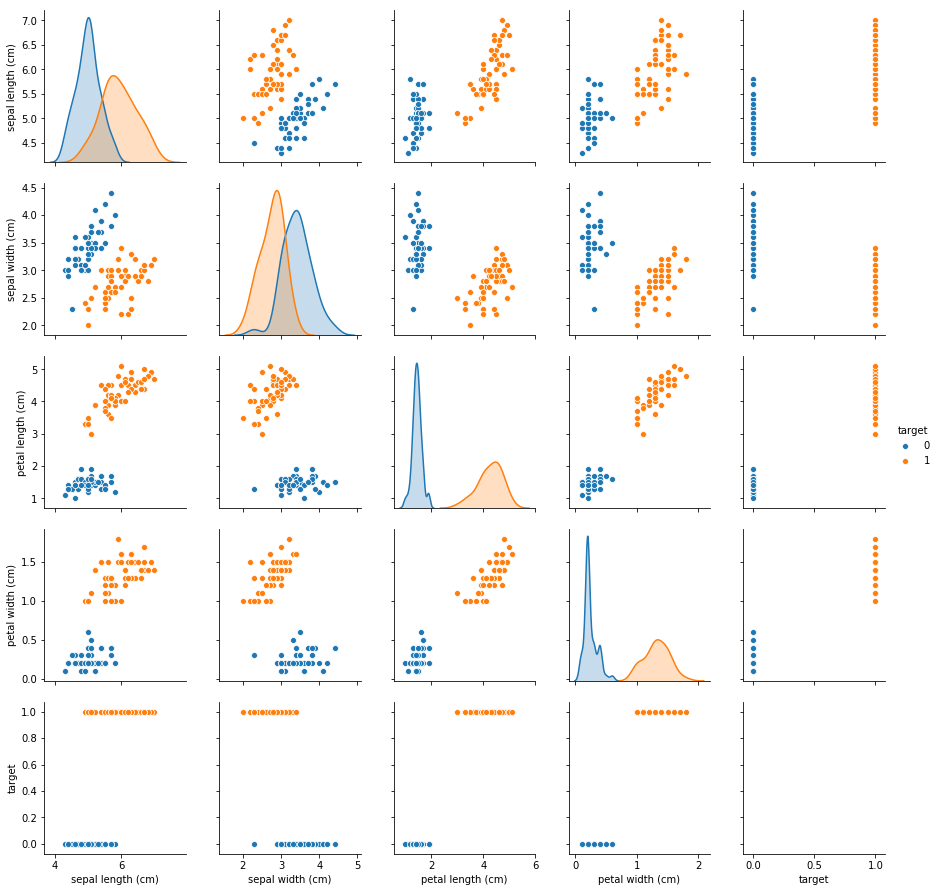

In [51]:
import seaborn as sns
# JupyterLab で実行する際は、この行を書くことで描画できるようになります。
%matplotlib inline

sns.pairplot(df_new , hue="target")

In [ ]:
X = np.array([[1,2],[3,4],[5,7],[8,9],[10,12]])
y = np.array([0,0,1,1,1]).reshape(-1,1)
#y = np.array([0,0,1,1,1])
print(y.flatten().flatten())
print(y)

In [37]:
collections.Counter(y.

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [192]:
decidion.threshold

X = np.array([[1,2],[3,4],[5,7],[8,9],[10,12]])
y = np.array([0,0,1,1,1])
left_node_list = np.empty((0,X.shape[1]))
left_node_list

array([], shape=(0, 2), dtype=float64)

In [195]:
X_1 = np.append(left_node_list,X,axis=0)
G_1 = np.append(X_1,y,axis=0)
G_1 

array([[ 1.,  2.],
       [ 3., 57.]])

In [197]:
X[0]

array([1, 2])